target                       0.000000
sensor1_measure              0.000000
sensor2_measure             77.215000
sensor3_measure              5.558333
sensor4_measure             24.768333
sensor5_measure              4.166667
sensor6_measure              4.166667
sensor7_histogram_bin0       1.118333
sensor7_histogram_bin1       1.118333
sensor7_histogram_bin2       1.118333
sensor7_histogram_bin3       1.118333
sensor7_histogram_bin4       1.118333
sensor7_histogram_bin5       1.118333
sensor7_histogram_bin6       1.118333
sensor7_histogram_bin7       1.118333
sensor7_histogram_bin8       1.118333
sensor7_histogram_bin9       1.118333
sensor8_measure              1.075000
sensor9_measure              1.048333
sensor10_measure             1.048333
sensor11_measure             7.333333
sensor12_measure             1.070000
sensor13_measure             1.048333
sensor14_measure             1.070000
sensor15_measure             0.981667
sensor16_measure             1.070000
sensor17_mea

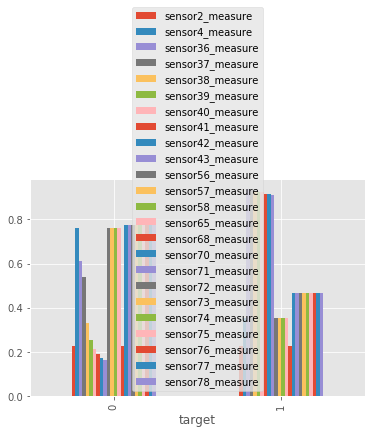

(47865, 147)


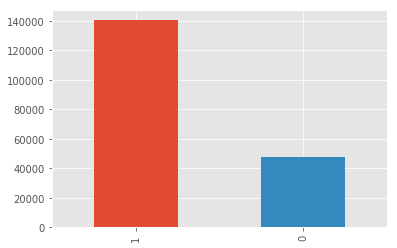

Minimum value: 0.009999999776482582


In [113]:
 import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
plt.style.use('ggplot')



df = pd.read_csv('equip_failures_training_set.csv')
df.drop(columns = 'id',inplace = True)


# many columns that are inhereintly numeric appear as type object. Get rid of this
obj_float = df.select_dtypes(object).apply(pd.to_numeric, downcast = 'float', errors = 'ignore')
df[obj_float.columns] = obj_float.values # make changes to ORIGINAL df in-place
df.dtypes


# replace 'na' with np.nan and count missing values
df.replace('na',np.nan,inplace = True)
total_missing = df.isnull().apply(sum)
missing_percentages = (total_missing / df.shape[0]) * 100
print(missing_percentages)
null_20 = missing_percentages[missing_percentages > 20]
filled_cols= missing_percentages[missing_percentages < 20].index # grab columns whose null values is less than 20%
print(null_20)

# perform above but groupby with target. the iloc is to get rid of "target" column
null_percent_bytarget = df.groupby('target').apply(lambda x: x.notnull().mean()).iloc[:,1:]
# perform average of both values
null_percent_bytarget.values.mean(axis = 1)

# Plot top 24 columns with missing values based on null_20 results
top_24 = null_20.index
print(top_24)

null_percent_bytarget[top_24].plot.bar();plt.show()


'''
Above does NOT find ANY missing values, despite the data clearly having null values.\
Why is that? Nulls are classified as 'na' values. Thus, we have to find a way to replace
EACH 'na' value by NULL for all functions to work properly
'''

# take df cols that have less than 20 percent missing value AND drop all rows containing na values
best_case = df[filled_cols].dropna()
print(best_case.shape)

pd.value_counts(best_case.target) / best_case.shape[0]
pd.value_counts(best_case.target)

# perform bootsrap
ones = best_case.groupby('target').get_group(1)
upper_limit = ones.shape[0]
x = 140033 # number of extra samples needed to increase 0 category to 30% of overall values

random_indexing = np.random.randint(0,upper_limit ,size = x)

values = []
for random in random_indexing:
    values.append(ones.iloc[random,:].values)

values = np.array(values)
values.shape # verified that this worked as it should

# merge values with best_case
vals_df = pd.DataFrame(values, columns = best_case.columns)

boot_best_case = pd.concat([best_case,vals_df])

# plot percentages of target again
pd.value_counts(boot_best_case.target) / boot_best_case.shape[0]
pd.value_counts(boot_best_case.target)
pd.value_counts(boot_best_case.target).plot.bar();plt.show() # this looks MUCH better

######################## PHASE 3: PCA ####################################
'''
Below code was NOT implemented as there are MANY zero values. Maybe find a way to get rid of this problem? Also, 
I did NOT normalize because they all seem to be sensory data. However, their range of values VARY WIDELY, thus, look
at some basic statistics with df.describe()


from scipy.stats import zscore
normalized = boot_best_case.set_index('target').apply(zscore).dropna()
'''
# fix pca by turning data frame to floats
obj_float = boot_best_case.select_dtypes(object).apply(pd.to_numeric, downcast = 'float', errors = 'ignore')
boot_best_case[obj_float.columns] = obj_float.values # make changes to ORIGINAL df in-place
# check new datatypes
boot_best_case.dtypes




# finding Statisticsc per column. Range of values are WAYYYYY too bad, we need to unnormalize them.
boot_best_case.describe()

# Find minimum c value that
boot_best_case.iloc[:,1:].drop(0,axis = 0).min()
c = (boot_best_case.apply(lambda x: x[x != 0].min())).min()
print("Minimum value:",c)





################ PHASE 4: Count Percentage of zero columns ###################
rows = boot_best_case.shape[0]
zero_total_percentages = boot_best_case.apply(lambda x: (1-(np.count_nonzero(x) / rows) )*100).sort_values()[::-1] # count percentage of zero numbers

# Extract columns with < 50% zeros values
less_cols = zero_total_percentages[zero_total_percentages < 50].index
reduced_df = boot_best_case[less_cols]
reduced_df[reduced_df.isna()]

# perform log transformation
logged = reduced_df.copy()
logged.iloc[:,1:] = reduced_df.iloc[:,1:].apply(lambda x: np.log(x + c)).values






In [114]:
# perform log transformation
reduced_df.set_index('target',drop =True,inplace = True)
logged = reduced_df.copy()
logged.iloc[:,:] = reduced_df.iloc[:,:].apply(lambda x: np.log(x + c)).values
logged.reset_index(inplace = True)



In [115]:
y = logged.target
logged = logged.drop('target', axis = 1)

In [116]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)


In [117]:
logged.head(10)

,sensor62_measure,sensor7_histogram_bin3,sensor26_histogram_bin9,sensor69_histogram_bin8,sensor63_measure,sensor55_measure,sensor24_histogram_bin6,sensor64_histogram_bin9,sensor31_measure,sensor69_histogram_bin7,...,sensor27_measure,sensor67_measure,sensor46_measure,sensor47_measure,sensor1_measure,sensor59_measure,sensor61_measure,sensor45_measure,sensor48_measure,sensor54_measure
0,1.793425,-4.605170,-4.605170,4.770770,7.562167,12.414078,15.259994,7.382753,3.912223,10.178465,...,15.717650,15.717650,15.717650,15.717650,11.247631,15.472929,13.728392,11.247632,15.702564,14.0058
1,-4.605170,-4.605170,8.457021,3.091497,-4.605170,-4.605170,13.557673,4.025530,5.857962,9.121292,...,15.109323,15.109323,15.109323,15.109323,10.406019,14.644533,13.374735,10.406004,15.091441,14.0058
2,-4.605170,-4.605170,-4.605170,5.505372,-4.605170,11.056083,13.676772,3.332561,1.388791,9.722086,...,14.798839,14.798839,14.798839,14.798839,10.622303,14.658237,12.372008,10.622305,14.800780,14.0058
3,0.698135,5.762083,-4.605170,-4.605170,2.773214,5.710460,-4.605170,-4.605170,-4.605170,-4.605170,...,9.981097,9.981097,9.981097,9.981097,2.485740,7.666245,8.417472,2.541602,9.988380,14.0058
4,-4.605170,-4.605170,-4.605170,5.318169,6.614739,11.818349,14.571122,4.454463,0.698135,10.009109,...,15.271625,15.271625,15.271625,15.271625,11.016562,15.086866,12.845586,11.016562,15.270242,14.0058
5,0.698135,-4.605170,-4.605170,4.454463,6.001440,11.225057,13.964570,5.298368,1.388791,9.659632,...,14.828134,14.828134,14.828134,14.828134,10.553518,14.682610,12.547168,10.553531,14.831656,14.0058
6,-4.605170,-4.605170,3.526654,-4.605170,3.258481,-4.605170,-4.605170,-4.605170,-4.605170,6.410192,...,9.599948,9.599948,9.599948,9.599948,2.639771,7.595453,8.002845,2.618855,9.660780,14.0058
7,4.955897,-4.605170,-4.605170,5.863659,7.239940,12.064625,14.259246,5.656027,2.485740,10.538794,...,15.729668,15.729668,15.729668,15.729668,11.542096,15.536048,13.152859,11.542105,15.732505,14.0058
8,0.698135,-4.605170,-4.605170,5.135857,6.843760,-4.605170,13.708121,6.960357,6.866944,10.496372,...,15.836706,15.836706,15.836706,15.836706,11.273348,15.495124,14.399460,11.273351,15.836273,14.0058
9,-4.605170,9.376195,-4.605170,-4.605170,2.080691,-4.605170,-4.605170,-4.605170,5.683614,7.946621,...,15.785022,15.785022,15.785022,15.785022,11.939526,16.508745,15.700650,11.939523,13.879326,14.0058


In [118]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(logged,y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [119]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [120]:
y_pred = classifier.predict(X_valid)

In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      9487
         1.0       1.00      1.00      1.00     28093

   micro avg       1.00      1.00      1.00     37580
   macro avg       1.00      1.00      1.00     37580
weighted avg       1.00      1.00      1.00     37580



In [137]:
missing = df.isnull().sum()
missing = ((missing/60000)*100).round(2)
drop_nas = list(missing[missing > 20].index)
len(drop_nas)
df.shape

(60000, 102)

In [130]:
df = df.drop(drop_nas, axis = 1)

In [132]:
target = df.target 

In [136]:
df.shape

(60000, 102)

In [134]:
df = df[logged.columns]

In [135]:
df.shape

(60000, 102)

In [138]:
ints = df.select_dtypes(object).apply(pd.to_numeric,downcast = 'signed')
df[ints.columns] = ints.values

In [140]:
#df.isnull().sum()

In [141]:
df = df.join(target)

In [143]:
df = df.dropna(axis = 0)

In [144]:
df.shape

(47865, 103)

In [147]:
target = df.target
df = df.drop('target', axis = 1)
df.shape

(47865, 102)

In [148]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(df,target, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [149]:
model_2  = classifier.fit(X_train_2, y_train_2)

In [150]:
y_pred = model_2.predict(X_valid_2)

In [151]:
print(classification_report(y_valid_2, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9497
           1       0.62      0.32      0.42        76

   micro avg       0.99      0.99      0.99      9573
   macro avg       0.80      0.66      0.71      9573
weighted avg       0.99      0.99      0.99      9573



In [172]:
X_test = pd.read_csv('equip_failures_test_set.csv', index_col = 'id')

In [173]:
X_test = X_test[logged.columns]

In [174]:
X_test = X_test.replace('na',np.nan)

In [176]:
names = X_test.columns

In [177]:
ints = X_test.select_dtypes(object).apply(pd.to_numeric,downcast = 'signed')
X_test[ints.columns] = ints.values

In [178]:
from sklearn.impute import SimpleImputer

In [179]:
my_imputer = SimpleImputer(strategy = 'median')
X_test = pd.DataFrame(my_imputer.fit_transform(X_test))

# Imputation removed column names; put them back
X_test.columns = X_test.columns

In [181]:
X_test.columns = names

In [183]:
X_test.shape

(16001, 102)

In [184]:
new = X_test.apply(lambda x: np.log(x + c))

In [186]:
new.head()

,sensor62_measure,sensor7_histogram_bin3,sensor26_histogram_bin9,sensor69_histogram_bin8,sensor63_measure,sensor55_measure,sensor24_histogram_bin6,sensor64_histogram_bin9,sensor31_measure,sensor69_histogram_bin7,...,sensor27_measure,sensor67_measure,sensor46_measure,sensor47_measure,sensor1_measure,sensor59_measure,sensor61_measure,sensor45_measure,sensor48_measure,sensor54_measure
0,-4.60517,-4.605170,-4.605170,4.955897,-4.605170,11.749009,15.003127,-4.605170,1.388791,10.174888,...,15.350339,15.350339,15.350339,15.350339,11.110775,15.161776,13.339156,11.110788,15.346094,14.0058
1,-4.60517,-4.605170,-4.605170,0.698135,1.793425,-4.605170,14.483230,5.950669,2.890927,9.067625,...,15.694228,15.694228,15.694228,15.694228,11.419955,15.544666,13.276898,11.419949,14.643532,14.0058
2,-4.60517,14.027703,12.875864,1.793425,1.793425,8.133297,13.730397,3.828859,0.698135,10.380343,...,14.684103,14.683742,14.683742,14.683742,12.296480,16.227753,13.922605,12.296482,14.643532,14.0058
3,-4.60517,-4.605170,-4.605170,-4.605170,2.485740,6.214628,-4.605170,-4.605170,-4.605170,0.698135,...,10.402261,10.402261,10.402261,10.402261,2.773214,8.040347,7.957853,2.733718,10.460643,14.0058
4,-4.60517,-4.605170,-4.605170,0.698135,-4.605170,11.467279,14.275324,7.420585,2.080691,9.424323,...,14.847584,14.847584,14.847584,14.847584,10.573469,14.562880,12.553692,10.573460,14.838153,14.0058


In [187]:
model_3  = classifier.fit(logged, y)


In [188]:
y_pred = classifier.predict(new)

In [190]:
output = pd.DataFrame({'Id': X_test.index,
                       'target': y_pred})
output.to_csv('conocophillips_challenge', index=False)